<a href="https://colab.research.google.com/github/jehee-lee/Aerospace_capstone_design/blob/main/Estimation_and_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Estimation and filtering


Original lecture)

EE370: Software lab, Kyung Hee University.
Jong-Han Kim (jonghank@khu.ac.kr)
https://nbviewer.jupyter.org/gist/jonghank/46597214ce4d62067e752402114527c3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(370)

A = np.zeros((2,2))
B = np.zeros((2,1))
C = np.zeros((1,2))

N = 1000 #number of timesteps

x = np.zeros((2,N+1))
x[:,0]=[0,0]
y = np.zeros((1,N))

이제 known factor를 입력한다.

In [ ]:
T=50 #time will vary from 0 to T with step delt
ts = np.linspace(0, T, N+1)
del_t = T/N # delta_t = 0.05 = 50 / 1000
gamma = 0.05 #damping


A[0,0] = 1
A[0,1] = (1-gamma*del_t/2)*del_t
A[1,1] = 1 - gamma*del_t

B[0,0] = del_t**2/2
B[1,0] = del_t

C[0,0] = 1

이 때, 외란(disturbace) factor와 잡음(noise)factor를 정규분포 난수로 설정한다.

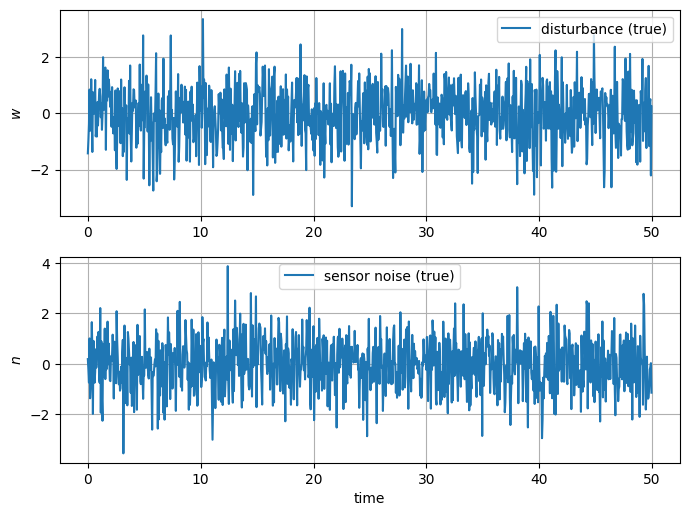

In [ ]:
w = np.random.randn(1,N)
n = np.random.randn(1,N)

w_true = w.copy()
n_true = n.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[:-1],w_true[0,:], label='disturbance (true)')
plt.ylabel(r"$w$")
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts[:-1],n_true[0,:], label='sensor noise (true)')
plt.xlabel('time')
plt.ylabel(r'$n$')
plt.legend()
plt.grid()
plt.show()

이후 해당 모델을 계산한 뒤 그래프로 나타낸다.

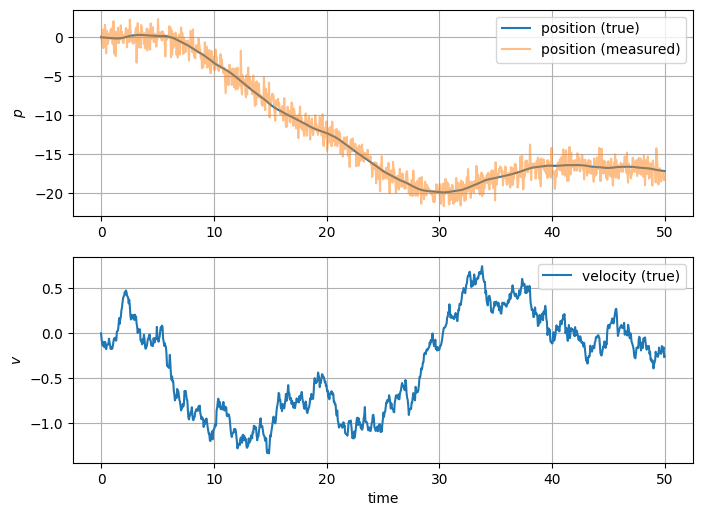

In [ ]:
for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])

x_true = x.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[:-1],y[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

In [ ]:
x.shape, y.shape, n.shape, w.shape, ts.shape

((2, 1001), (1, 1000), (1, 1000), (1, 1000), (1001,))

# 1) Naive estimates

In [ ]:
p_naive = np.zeros((1,N))
v_naive = np.zeros((1,N))

p_naive = y.copy()

for t in range(N):
  v_naive[:,t] = (p_naive[:,t] - p_naive[:,t-1])/del_t

p_naive.shape, v_naive.shape

((1, 1000), (1, 1000))

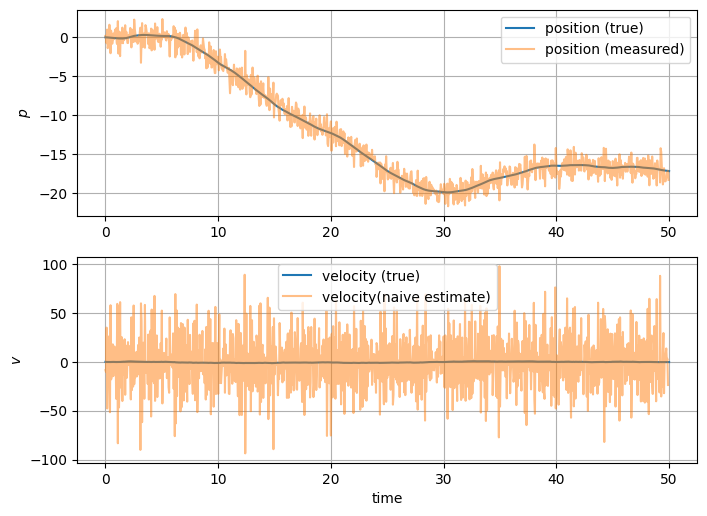

In [ ]:
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], label='position (true)')
plt.plot(ts[:-1],p_naive[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.plot(ts[:-2], v_naive[0,1:],alpha=0.5, label = "velocity(naive estimate)")
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

y에서 계측된 noise가 velocity(naive estimate)에 영향을 미친다.

# 2) Low Pass Filter

In [ ]:
p_lpf = np.zeros((1,N+1))
v_lpf = np.zeros((1,N))

a,b = 0.9047619, 0.04761905


#low pass filter for position
for t in range(N-1):
  p_lpf[:,t+1] = a*p_lpf[:,t]+b*(p_naive[:,t+1]+p_naive[:,t])

a, b = 0.99004975, 0.00497512
#low pass filter for velocity
for t in range(N-1):
  v_lpf[:,t+1] = a*v_lpf[:,t]+b*(v_naive[:,t+1]+v_naive[:,t])

p_lpf.shape, v_lpf.shape

((1, 1001), (1, 1000))

해당 함수를 이용해 a, b 를 구한듯? but 어떤 함수인지 모름

In [ ]:
import scipy.signal as sps
bw_p = 2
bw_v = 0.2
lpf_p = sps.cont2discrete(([bw_p],[1.,bw_p]), del_t, method='bilinear')
lpf_v = sps.cont2discrete(([bw_v],[1.,bw_v]), del_t, method='bilinear')
print(lpf_p)
print(lpf_v)

(array([[0.04761905, 0.04761905]]), array([ 1.       , -0.9047619]), 0.05)
(array([[0.00497512, 0.00497512]]), array([ 1.        , -0.99004975]), 0.05)


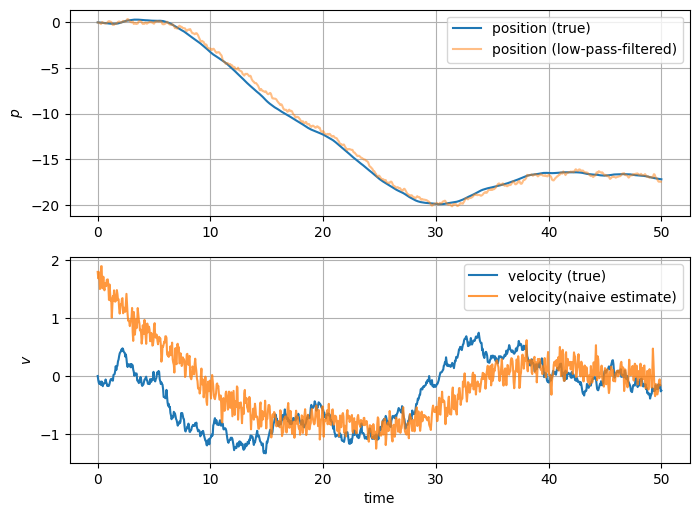

In [ ]:
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], label='position (true)')
plt.plot(ts[:-1],p_lpf[0,:-1], alpha=0.5, label='position (low-pass-filtered)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.plot(ts[:-2], v_lpf[0,1:],alpha=0.8, label = "velocity(naive estimate)")
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

position은 상당히 정확하게 예측이 되지만, velocity는 제대로 예측하지 못함

# 3) alpha-beta filter

In [ ]:
p_ab = np.zeros((1,N))
p_hat=np.zeros((1,N+1))
v_ab = np.zeros((1,N))
v_hat = np.zeros((1,N+1))

#뭔가 alpha, beta값이 적당히 작아야 값이 비슷한듯 하다?
alpha, beta = 0.2, 0.005

for t in range(N):
  p_ab[:,t] = p_hat[:,t-1]+v_hat[:,t-1]*del_t
  v_ab[:,t] = v_hat[:,t-1]
  p_hat[:,t+1] = p_ab[:,t]+alpha*(y[:,t]-p_ab[:,t])
  v_hat[:,t+1] = v_ab[:,t]+beta*(y[:,t]-p_ab[:,t])/del_t

In [ ]:
p_ab.shape, p_hat.shape, v_ab.shape, v_hat.shape

((1, 1000), (1, 1001), (1, 1000), (1, 1001))

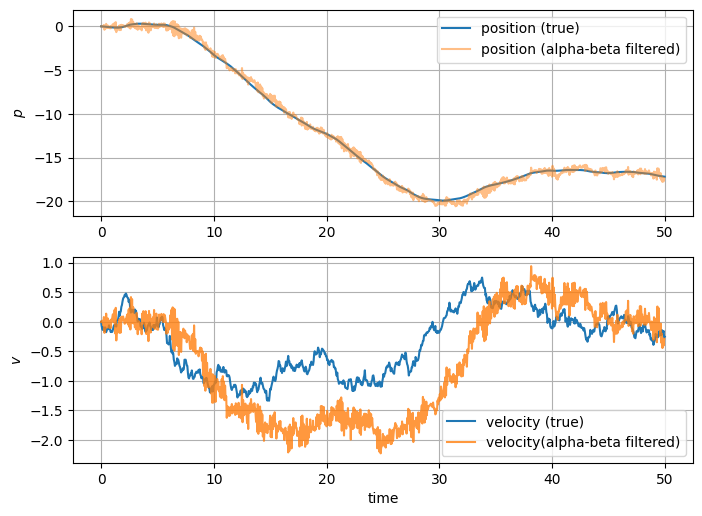

In [ ]:
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], label='position (true)')
plt.plot(ts[:-1],p_ab[0,:], alpha=0.5, label='position (alpha-beta filtered)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.plot(ts[:-1], v_ab[0,:],alpha=0.8, label = "velocity(alpha-beta filtered)")
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

In [ ]:
x_es = np.zeros((2,N+1))
y_es = np.zeros((1,N))
x_prop = np.zeros((2,N))
y_prop = np.zeros((1,N))
cov=np.eye(2,2)
cov_n = np.eye(1)
cov_w = np.dot(B,B.T)

def dot3(X,Y,Z):
  return X.dot(Y).dot(Z)

def rev(X):
  return np.linalg.inv(X)


#Kalman gain

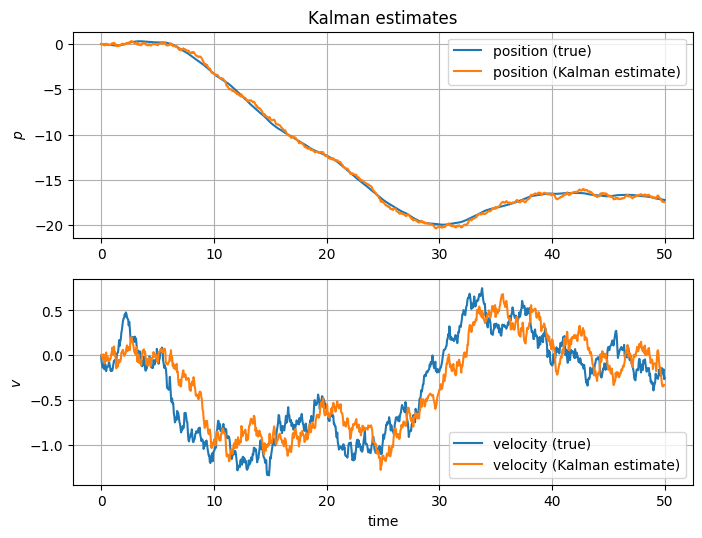

In [247]:
for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])

for t in range(N):
  x_prop[:,t] = A@x_es[:,t]
  y_es[:,t] = C@x_es[:,t]
  K=A@cov@C.T@rev(C@cov@C.T+1)
  x_es[:,t+1] = x_prop[:,t]+K@(y[:,t]-y_es[:,t])
  cov=A@cov@A.T-K@C@cov@A.T+cov_w

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], label='position (true)')
plt.plot(ts[:-1],x_prop[0,:], alpha=1, label='position (Kalman estimate)')
plt.ylabel(r'$p$')
plt.title('Kalman estimates')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.plot(ts[:-1],x_prop[1,:], alpha=1, label='velocity (Kalman estimate)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

면담 결과

1. 정규분포 분포 노이즈를 사용하는 이유는 칼만 필터가 가우시안 분포상의 오차에 대해 우수한 값을 보이기 때문이다.

2. cont2discrete 함수는 선형보간함수라기보단 근을 찾는 함수에 가깝다.(개인적으로 이해하기에는) 따라서 기계학습으로 보기 어렵다.

3. FIR방식과 IIR방식의 차이

필터에는 식을 갱신할 때 이전 데이터를 활용하는 방식의 IIR방식과

(Ex: Y_n+1 = A*Y_n+B
*input_n+1]

이전 데이터를 활용하지 않는 FIR방식이 있다.

(Ex: Y_n+1 = C*input_n+1)

problem1을 제외한 나머지 필터는 전부 IIR방식이며, 단층 지도학습으로 인해 나오는 layer는 FIR이 될 것이다.

추후 과제

1. 단층 지도학습(기계학습)을 통해 mse최적화 학습을 진행했을 때, input data의 크기가 얼마나 커야 유의미한 결과가 나오는지 알아보기 (ex: 지도학습용 데이터의 크기가 200일 때와 10일 때 비교)

2. 해당 기계학습의 결과가 칼만필터를 비롯한 다른 필터와 비교했을 때 정확도가 우수한지?

3. 정규분포가 아닌 임의의 노이즈에 대해서 다른 필터에 비해 정확도가 우수한지? (칼만필터와 비교했을 때 정규분포 노이즈에 대해서 더 우수한 모델이 나오기 어렵기 때문에, 다른 임의의 노이즈와 비교할 필요가 있다.)

4. layer를 추가하여 DNN을 구현했을 때의 정확도와 비교하기

5. 불연속 데이터에 대해서(데이터가 N초에 한 번씩만 수신된다던지)에 대해서 예측하기 위한 모델을 구현할 수 있는지?